# Score Genes

## Description

Create biaxial visualizations of cells grouped/colored by chosen cell-level metadata labels.  

This notebook was designed to run on Terra, but with a small enough dataset and several tweaks to the code, it should be runnable locally. On Terra, create a custom environment with the image address `shaleklab/alxscoregenes:0.21`, as few CPUs as possible, anywhere from 8 to 32GB RAM, and 50GB persistent disk space. The RAM you need may need to be much larger depending on the size of the dataset you have.

## What you should know:

### Alexandria
Alexandria is a single-cell portal and data resource for the global health community. Alexandria will use unified pipelines and interactive notebooks to preprocess, store, and visualize datasets of interest to the global health community, enabling rapid realization of transformative insights and the prioritization of follow-ups. For further information you can visit the [Alexandria Portal](https://singlecell.broadinstitute.org/single_cell?scpbr=the-alexandria-project), the [documentation](https://alexandria-scrna-data-library.readthedocs.io/en/latest/introduction.html), or the [GitHub repository](https://github.com/ShalekLab/alexandria#the-alexandria-project)

### Terra
[Terra.bio](https://terra.bio/) is a scalable research platform for biomedical research that is built upon Google Cloud Platform. Alexandria Notebooks are designed to run upon Terra and similar cloud notebook platforms. Within a Terra workspace, a notebook runtime can be created with custom parameters. It is recommended you use at least 16 GB RAM, 50 GB persistent disk size, and an application configuration which has all the packages and dependencies the notebook requires. You can use the following notebook code chunks to import and export your data. With a [persistent disk](https://support.terra.bio/hc/en-us/articles/360047318551), your data should be retained when the runtime is deleted/recreated. For more information on Terra Notebooks, please see the [Terra documentation](https://support.terra.bio/hc/en-us/sections/360004143932-Visualization-and-Statistics-notebooks-).

### Google Cloud Storage
In a Terra notebook runtime and its associated cloud shell, you should have access to `gsutil`: a commandline tool which can be used to interact with Google Storage buckets and objects. Within the Terra notebook runtime, you must use `gsutil cp` to copy folders/files from a Google Storage endpoint to a destination within the VM. The code cells in the following section will help you move the data. Read more about [gsutil](https://cloud.google.com/storage/docs/gsutil) and [how you can use it with Terra notebooks](https://support.terra.bio/hc/en-us/articles/360024056512-Moving-data-to-from-a-workspace-Google-bucket).

### Scanpy
Scanpy is a scalable toolkit for analyzing single-cell gene expression data. It includes preprocessing, visualization, clustering, trajectory inference and differential expression testing. The Python-based implementation efficiently deals with datasets of more than one million cells. Read more about Scanpy on the [Scanpy documentation](https://scanpy.readthedocs.io/en/stable/).


## Import data
Please edit the below addresses:
* `source_bucket`: The path to the folder on the bucket containing your counts, gene list, metadata, and (optionally) visualization files.
* `destination_vm`: The path on the virtual machine where you wish to send these files for loading into the notebook. The default should suffice.

The files your `source_bucket` folder should contain are:
* `counts`: The cell by gene counts table file
* `cell_metadata`: The cell-level metadata table file.
* `genelist`: The gene list table file.
* *Optional* `viz_coords`: The coordinates file for a UMAP or TSNE visualization.

*See the appendix (bottom-most section) of the notebook to view what these files look like!*

In [1]:
import subprocess as sp
import os
import os.path as osp
import scanpy as sc
import pandas as pd
import seaborn as sns

source_bucket = "gs://fc-secure-ec2ce7e8-339a-47b4-b9d9-34f652cbf41f/data/scoregenes/epi/" # "gs://bucket/path/to/datafolder/"
destination_vm = "/home/jupyter-user/notebooks/data"

source_bucket = source_bucket.rstrip('/') + '/' # Ensure trailing '/'
if not osp.isdir(destination_vm):
    os.makedirs(destination_vm)
command = f"gsutil cp -r {source_bucket} {destination_vm}"
sp.check_call(command.split())
destination_vm = osp.join(destination_vm, osp.basename(osp.dirname(source_bucket)))
print(f"Your files will be found in {destination_vm}")
os.listdir(destination_vm)

Your files will be found in /home/jupyter-user/notebooks/data/epi


['epithelial_metadata_alexandria.txt',
 'h.all.v6.2.symbols.transpose.csv',
 'epithelial_cells_for_scp.txt.gz',
 'all_epi_counts.txt.gz',
 'epi_cells_umap.txt']

## Read data
Your count data may be in a different format than the plain text tab-separated values file listed below. You can visit the [scanpy documentation page on reading](https://scanpy.readthedocs.io/en/stable/api/index.html#reading) to find the function you will need to read the data in as an Anndata object.

It is recommended your cell metadata file conform to the [Alexandria Metadata Convention](https://alexandria-scrna-data-library.readthedocs.io/en/latest/metadata.html) which is compatible with the Alexandria Portal. For this notebook however, your metadata labels can be anything you desire.

In [3]:
# REQUIRED
counts = destination_vm + '/' + "all_epi_counts.txt.gz"
cell_metadata =  destination_vm + '/' + "epithelial_metadata_alexandria.txt"
genelist = destination_vm + '/' + "h.all.v6.2.symbols.transpose.csv"

# OPTIONAL
# Tabular file containing X and Y coords of each cell
viz_coords = destination_vm + '/' + "epi_cells_umap.txt"
viz_type = "umap" # either "umap" or "tsne"
viz_is_normalized = False # Change to True if normalized.


In [4]:
# Create Anndata object from counts
adata = sc.read_csv(counts, delimiter='\t')
adata.X

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0., 18.],
       [ 5.,  0.,  0., ...,  0.,  0.,  6.],
       ...,
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [5]:
# Create metadata dataframe and assign to the Anndata object
metadata_df = pd.read_csv(cell_metadata, sep='\t', index_col=0)[1:]
adata.obs = metadata_df.loc[adata.obs_names]
adata.obs

,species,species__ontology_label,library_preparation_protocol,library_preparation_protocol__ontology_label,CellID,organ,organ__ontology_label,donor_id,biosample_id,number_of_reads,...,disease__ontology_label,cell_type,cell_type__ontology_label,sample_type,Granuloma,sequencing_instrument_manufacturer_model__ontology_label,sequencing_instrument_manufacturer_model,paired_ends,read_length,end_bias
Array8_28818_AAGCAGCCACCT,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array8_28818_AAGCAGCCACCT,UBERON_0002171,lower lobe of right lung,28818,Array8_28818,5156,...,tuberculosis,CL_0002063,type II pneumocyte,direct from donor - fresh,Granuloma,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array8_30218_CACAGCCAGAGA,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array8_30218_CACAGCCAGAGA,UBERON_0002171,lower lobe of right lung,30218,Array8_30218,92117,...,tuberculosis,CL_0002063,type II pneumocyte,direct from donor - fresh,Granuloma,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array8_30218_CGCACTAAACCT,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array8_30218_CGCACTAAACCT,UBERON_0002171,lower lobe of right lung,30218,Array8_30218,54083,...,tuberculosis,CL_0002063,type II pneumocyte,direct from donor - fresh,Granuloma,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array8_30218_CCGGAGCGATGA,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array8_30218_CCGGAGCGATGA,UBERON_0002171,lower lobe of right lung,30218,Array8_30218,53325,...,tuberculosis,CL_0002063,type II pneumocyte,direct from donor - fresh,Granuloma,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array8_30218_GGAAAACCATCG,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array8_30218_GGAAAACCATCG,UBERON_0002171,lower lobe of right lung,30218,Array8_30218,49539,...,tuberculosis,CL_0002063,type II pneumocyte,direct from donor - fresh,Granuloma,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array5_29818_CGCCCCTATCTT,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array5_29818_CGCCCCTATCTT,UBERON_0008953,lower lobe of left lung,29818,Array5_29818,41697,...,tuberculosis,CL_0002062,type I pneumocyte,direct from donor - fresh,Uninvolved lung,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array5_29818_CACCGCTCGCTT,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array5_29818_CACCGCTCGCTT,UBERON_0008953,lower lobe of left lung,29818,Array5_29818,30695,...,tuberculosis,CL_0000151,secretory cell,direct from donor - fresh,Uninvolved lung,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array5_29818_AGCGAGCGTAGG,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array5_29818_AGCGAGCGTAGG,UBERON_0008953,lower lobe of left lung,29818,Array5_29818,15493,...,tuberculosis,CL_0002062,type I pneumocyte,direct from donor - fresh,Uninvolved lung,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias
Array5_29818_GCAGTGAACATG,NCBITaxon_9541,Macaca fascicularis,EFO_0008919,Seq-Well,Array5_29818_GCAGTGAACATG,UBERON_0008953,lower lobe of left lung,29818,Array5_29818,16273,...,tuberculosis,CL_0000067,ciliated epithelial cell,direct from donor - fresh,Uninvolved lung,Illumina NovaSeq 6000,EFO_0008637,True,20-50,3 prime end bias


In [6]:
# OPTIONAL: Create visualization dataframe and assign to Anndata object
viz_df = pd.read_csv(viz_coords, sep='\t', index_col=0)[1:]
adata.obsm[viz_type] = viz_df.astype(float)
if not viz_is_normalized:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
adata.obsm[viz_type]

,X,Y
NAME,,
Array8_28818_AAGCAGCCACCT,5.674537,2.569250
Array8_30218_CACAGCCAGAGA,6.818745,6.151183
Array8_30218_CGCACTAAACCT,7.038747,5.857894
Array8_30218_CCGGAGCGATGA,7.229948,5.366237
Array8_30218_GGAAAACCATCG,6.316346,0.591161
...,...,...
Array5_29818_CGCCCCTATCTT,2.365552,-7.787423
Array5_29818_CACCGCTCGCTT,3.983894,-1.543710
Array5_29818_AGCGAGCGTAGG,2.153387,-11.129201


In [7]:
def make_scores_from_file(adata, filename, sep='\t'):
    '''
    For use if the genelists are in a single file where the column names, score names, and the 
    rows are a bunch of genes (since genelists will be different lengths, this leads to a bunch 
    of empty entries in genelists and a lot of warnings but it doesnt matter)
    '''
    gene_lists = pd.read_csv(filename, sep=sep)
    for s in gene_lists:
        sc.tl.score_genes(adata, gene_lists[s], score_name=s)
    return gene_lists.columns # returns column names so you can see what the names of the scores are

In [8]:
# Read in a gene list and get a list of scores from the column header names.
# You can expect warnings if your columns are of different lengths (some contain NaN) which is fine!
scores = make_scores_from_file(adata, filename=genelist, sep=',')

In [9]:
scores

Index(['HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE',
       'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING',
       'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR',
       'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS',
       'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS',
       'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE',
       'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS',
       'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
       'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION',
       'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING',
       'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE',
       'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING',
       'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1',
       'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MES

In [10]:
labels = adata.obs.columns
labels

Index(['species', 'species__ontology_label', 'library_preparation_protocol',
       'library_preparation_protocol__ontology_label', 'CellID', 'organ',
       'organ__ontology_label', 'donor_id', 'biosample_id', 'number_of_reads',
       'is_living', 'sex', 'disease', 'disease__ontology_label', 'cell_type',
       'cell_type__ontology_label', 'sample_type', 'Granuloma',
       'sequencing_instrument_manufacturer_model__ontology_label',
       'sequencing_instrument_manufacturer_model', 'paired_ends',
       'read_length', 'end_bias', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
       'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS',
       'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_WNT_BETA_CATENIN_SIGNALING',
       'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING',
       'HALLMARK_DNA_REPAIR', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS',
       'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS',
       'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE

## Plot data

In [10]:
# Choose the scores you wish to compare and the label by which you wish to color/group cells.
score1 = "HALLMARK_TNFA_SIGNALING_VIA_NFKB"
score2 = "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
label = "cell_type__ontology_label"
destination_vm_outputs = "/home/jupyter-user/notebooks/data/outputs/"
if not os.path.isdir(destination_vm_outputs):
    os.makedirs(destination_vm_outputs)

In [11]:
def biaxial_plot(adata, score1, score2, color_by, group_by=None, save_as=None):
    '''
    Plots a biaxial plot of the two scores (must be in adata.obs) on the cells in the adata object. 
    Cells are colored by the categorical variable in `color_by`. If `groupby` is not None, it will split the scatter 
    plot into a faceted plot with each facet as the group
    '''
    if group_by is None:
        ax = sns.scatterplot(data=adata.obs, x=score1, y=score2, hue=color_by)
        figure = ax.figure
    else:
        figure = sns.relplot(data=adata.obs, x=score1, y=score2, hue=color_by, col=group_by)
    if save_as is not None:
        figure.savefig(save_as)

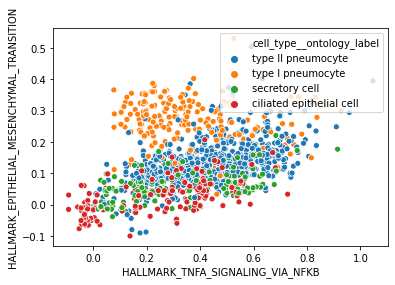

In [12]:
biaxial_plot(
    adata,
    score1=score1,
    score2=score2,
    color_by=label,
    group_by=None,
    save_as=osp.join(destination_vm_outputs, "output1.png")
)

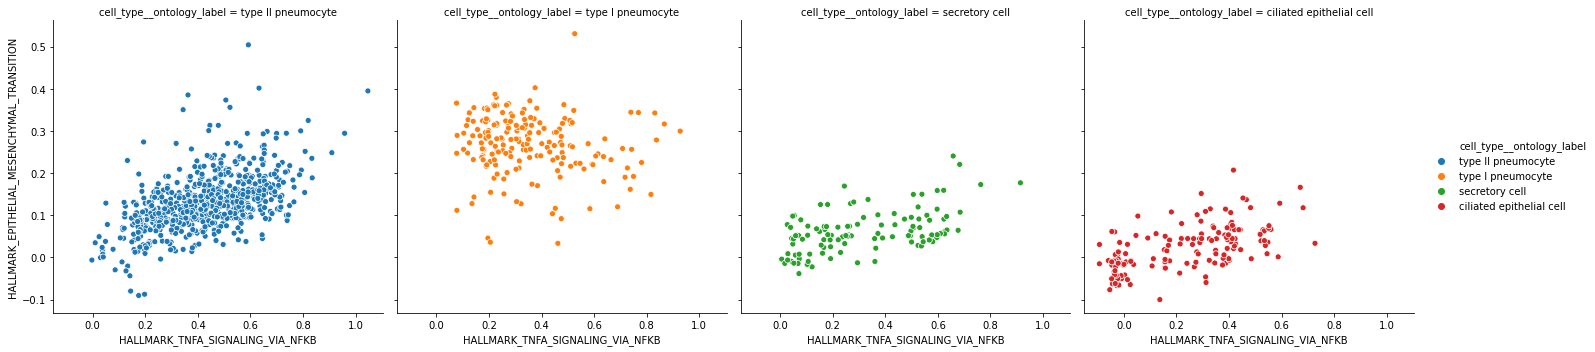

In [13]:
biaxial_plot(
    adata,
    score1=score1,
    score2=score2,
    color_by=label,
    group_by=label,
    save_as=osp.join(destination_vm_outputs, "output2.png")
)

## Export data
You only need to run this subsection when you wish to save your outputs back to the workspace bucket and delete your runtime.
For `destination_bucket`, enter a gsURI to which you wish to save the outputs.

In [14]:
source_vm = destination_vm_outputs
destination_bucket = "gs://fc-secure-ec2ce7e8-339a-47b4-b9d9-34f652cbf41f/data/scoregenes/savedata"


In [15]:
command = f"gsutil cp -r {source_vm} {destination_bucket}"
sp.check_call(command.split())


0

## Appendix: File format examples

In [24]:
# Cell x metadata tab-separated values file.
# While using Alexandria Metadata Convention labels is not mandatory, please adhere to the basic format:
# First row is metadata labels column headers
# IMPORTANT! Second row is additional column headers for that metadata label's datatype.
# First column below the headers are cell names
# All other columns beneath the headers are the corresponding cell and label's metadata.
with open(cell_metadata) as m:
    for line in m:
        print(line.rstrip())

NAME	species	species__ontology_label	library_preparation_protocol	library_preparation_protocol__ontology_label	CellID	organ	organ__ontology_label	donor_id	biosample_id	number_of_reads	is_living	sex	disease	disease__ontology_label	cell_type	cell_type__ontology_label	sample_type	Granuloma	sequencing_instrument_manufacturer_model__ontology_label	sequencing_instrument_manufacturer_model	paired_ends	read_length	end_bias
TYPE	group	group	group	group	group	group	group	group	group	numeric	group	group	group	group	group	group	group	group	group	group	group	group	group
Array10_28918_AAATGCGAACGG	NCBITaxon_9541	Macaca fascicularis	EFO_0008919	Seq-Well	Array10_28918_AAATGCGAACGG	UBERON_0002174	middle lobe of right lung	28918	Array10_28918	5604	no	unknown	MONDO_0018076	tuberculosis	CL_0000151	secretory cell	direct from donor - fresh	Uninvolved lung	Illumina NovaSeq 6000	EFO_0008637	True	20-50	3 prime end bias
Array10_28918_AACAGCTTCACG	NCBITaxon_9541	Macaca fascicularis	EFO_0008919	Seq-Well	Array10_2

In [23]:
# Gene lists have biological hallmark labels as the column headers
# Under these column headers are the significant genes associated with this biology.
# Notice that empty spreadsheet cells are permitted; not all hallmarks need to have the same number of genes.
with open(genelist) as g:
    for line in g:
        print(line.rstrip())

HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_DNA_REPAIR,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,HALLMARK_NOTCH_SIGNALING,HALLMARK_ADIPOGENESIS,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_MYOGENESIS,HALLMARK_PROTEIN_SECRETION,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_COMPLEMENT,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_E2F_TARGETS,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V2,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_XENOBIOTIC_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_GLYCOLYSIS,HALLMARK_REACTIVE_OXIGEN_

In [35]:
# Counts matrix ultimately needs to be read into a dataframe such as below.
# Cell x Gene matrix with transcript counts in each cell.
counts = pd.read_csv(counts, compression='gzip', header=0, sep='\t')
counts

,Unnamed: 0,A4GALT,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,...,LOC107126887,HFM1,LOC102128600,MIOX,LOC102140373,LOC102146613,CLDN2,NUTM1,LOC102141889,AOX4
0,Array8_28818_AAGCAGCCACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Array8_30218_CACAGCCAGAGA,1.0,1.0,0.0,12.0,0.0,0.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
2,Array8_30218_CGCACTAAACCT,5.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
3,Array8_30218_CCGGAGCGATGA,0.0,0.0,0.0,8.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
4,Array8_30218_GGAAAACCATCG,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,Array5_29818_CGCCCCTATCTT,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1088,Array5_29818_CACCGCTCGCTT,0.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1089,Array5_29818_AGCGAGCGTAGG,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1090,Array5_29818_GCAGTGAACATG,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Cell by X Y coordinates
# Format generated by Cumulus and Single Cell Portal
# IMPORTANT! The second row must be TYPE headers for the associated column headers (numeric for X and Y)
with open(viz_coords) as v:
    for line in v:
        print(line.rstrip())

NAME	X	Y
TYPE	numeric	numeric
Array8_28818_AAGCAGCCACCT	5.6745367	2.5692499
Array8_30218_CACAGCCAGAGA	6.818745	6.151183
Array8_30218_CGCACTAAACCT	7.0387473	5.857894
Array8_30218_CCGGAGCGATGA	7.2299485	5.366237
Array8_30218_GGAAAACCATCG	6.3163457	0.5911613
Array8_30218_TAATGCAGTTAC	8.251889	1.782613
Array8_30218_CCTTCATCTACT	5.316405	-1.6148348
Array8_30218_CTACCAGCTCCA	6.6429152	1.3874198
Array8_30218_TTTAAAGGGGTA	4.2862077	-1.3908616
Array8_30218_TGACCCGAGGCT	5.9919186	4.852479
Array8_30218_CCTATTGTGCAT	5.8709764	0.27561766
Array8_30218_CAATACAACGAT	3.7819626	-1.9124513
Array8_30218_TAAGAGAGTTCA	8.150139	1.2229862
Array8_30218_GTATTAAGAGCC	6.391985	4.132887
Array8_30218_TGTATGGTGGGC	-0.56670624	-9.231773
Array8_30218_TACCACGCCCCT	6.7182517	4.055295
Array8_30218_TTGCCCCCTGGC	8.218032	-0.36800152
Array8_30218_CTGTAGTTAAGT	0.7283204	-9.95567
Array8_30218_GGCGTCTTGATT	7.238572	5.496173
Array9_28818_CTCCAGTCACCC	2.6791286	-1.0083152
Array9_28818_CAGCACTGTTTG	5.519311	0.907063
Array9_28818_